In [ ]:
# default_exp models.nbeats.nbeats

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import os
import random
import time
from collections import defaultdict
from copy import deepcopy

import numpy as np
import pandas as pd
import torch as t
from torch import optim
from pathlib import Path
from functools import partial

from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader
from nixtla.models.nbeats.nbeats_model import NBeats, NBeatsBlock, IdentityBasis, TrendBasis, SeasonalityBasis
from nixtla.models.nbeats.nbeats_model import ExogenousBasisInterpretable, ExogenousBasisWavenet, ExogenousBasisTCN
from nixtla.losses.pytorch import MAPELoss, MASELoss, SMAPELoss, MSELoss, MAELoss, PinballLoss
from nixtla.losses.numpy import mae, mse, mape, smape, rmse, pinball_loss

In [ ]:
#export
def init_weights(module, initialization):
    if type(module) == t.nn.Linear:
        if initialization == 'orthogonal':
            t.nn.init.orthogonal_(module.weight)
        elif initialization == 'he_uniform':
            t.nn.init.kaiming_uniform_(module.weight)
        elif initialization == 'he_normal':
            t.nn.init.kaiming_normal_(module.weight)
        elif initialization == 'glorot_uniform':
            t.nn.init.xavier_uniform_(module.weight)
        elif initialization == 'glorot_normal':
            t.nn.init.xavier_normal_(module.weight)
        elif initialization == 'lecun_normal':
            pass #t.nn.init.normal_(module.weight, 0.0, std=1/np.sqrt(module.weight.numel()))
        else:
            assert 1<0, f'Initialization {initialization} not found'

class Nbeats(object):
    """
    Future documentation
    """
    SEASONALITY_BLOCK = 'seasonality'
    TREND_BLOCK = 'trend'
    IDENTITY_BLOCK = 'identity'

    def __init__(self,
                 input_size_multiplier,
                 output_size,
                 shared_weights,
                 activation,
                 initialization,
                 stack_types,
                 n_blocks,
                 n_layers,
                 n_hidden,
                 n_harmonics,
                 n_polynomials,
                 exogenous_n_channels,
                 batch_normalization,
                 dropout_prob_theta,
                 dropout_prob_exogenous,
                 x_s_n_hidden,
                 learning_rate,
                 lr_decay,
                 n_lr_decay_steps,
                 weight_decay,
                 l1_theta,
                 n_iterations,
                 early_stopping,
                 loss,
                 loss_hypar,
                 val_loss,
                 frequency,
                 random_seed,
                 seasonality,
                 device=None):
        super(Nbeats, self).__init__()
        """
        N-BEATS model.

        Parameters
        ----------
        input_size_multiplier: int
            Multiplier to get insample size.
            Insample size = input_size_multiplier * output_size
        output_size: int
            Forecast horizon.
        shared_weights: bool
            If True, repeats first block.
        activation: str
            Activation function.
            An item from ['relu', 'softplus', 'tanh', 'selu', 'lrelu', 'prelu', 'sigmoid'].
        initialization: str
            Initialization function.
            An item from ['orthogonal', 'he_uniform', 'glorot_uniform', 'glorot_normal', 'lecun_normal'].
        stack_types: List[str]
            List of stack types.
            Subset from ['seasonality', 'trend', 'identity', 'exogenous', 'exogenous_tcn', 'exogenous_wavenet'].
        n_blocks: List[int]
            Number of blocks for each stack type.
            Note that len(n_blocks) = len(stack_types).
        n_layers: List[int]
            Number of layers for each stack type.
            Note that len(n_layers) = len(stack_types).
        n_hidden: List[List[int]]
            Structure of hidden layers for each stack type.
            Each internal list should contain the number of units of each hidden layer.
            Note that len(n_hidden) = len(stack_types).
        n_harmonics: List[int]
            Number of harmonic terms for each stack type.
            Note that len(n_harmonics) = len(stack_types).
        n_polynomials: List[int]
            Number of polynomial terms for each stack type.
            Note that len(n_polynomials) = len(stack_types).
        exogenous_n_channels:
            Exogenous channels for non-interpretable exogenous basis.
        batch_normalization: bool
            Whether perform batch normalization. 
        dropout_prob_theta: float
            Float between (0, 1).
            Dropout for Nbeats basis.
        dropout_prob_exogenous: float
            Float between (0, 1).
            Dropout for exogenous basis.
        x_s_n_hidden: int
            Number of encoded static features to calculate.
        learning_rate: float
            Learning rate between (0, 1).
        lr_decay: float
            Decreasing multiplier for the learning rate.
        n_lr_decay_steps: int
            Period for each lerning rate decay.
        weight_decay: float
            L2 penalty for optimizer.
        l1_theta: float
            L1 regularization for the loss function.
        n_iterations: int
            Number of training steps.
        early_stopping: int
            Early stopping interations.
        loss: str
            Loss to optimize.
            An item from ['MAPE', 'MASE', 'SMAPE', 'MSE', 'MAE', 'PINBALL', 'PINBALL2'].
        loss_hypar:
            Hyperparameter for chosen loss.
        val_loss:
            Validation loss.
            An item from ['MAPE', 'MASE', 'SMAPE', 'RMSE', 'MAE', 'PINBALL'].
        frequency: str
            Time series frequency.
        random_seed: int
            random_seed for pseudo random pytorch initializer and
            numpy random generator.
        seasonality: int
            Time series seasonality.
            Usually 7 for daily data, 12 for monthly data and 4 for weekly data.
        device: Optional[str]
            If None checks 'cuda' availability.
            An item from ['cuda', 'cpu'].
        """

        if activation == 'selu': initialization = 'lecun_normal'

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.input_size = int(input_size_multiplier*output_size)
        self.output_size = output_size
        self.shared_weights = shared_weights
        self.activation = activation
        self.initialization = initialization
        self.stack_types = stack_types
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_harmonics = n_harmonics
        self.n_polynomials = n_polynomials
        self.exogenous_n_channels = exogenous_n_channels

        # Regularization and optimization parameters
        self.batch_normalization = batch_normalization
        self.dropout_prob_theta = dropout_prob_theta
        self.dropout_prob_exogenous = dropout_prob_exogenous
        self.x_s_n_hidden = x_s_n_hidden
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.n_lr_decay_steps = n_lr_decay_steps
        self.weight_decay = weight_decay
        self.n_iterations = n_iterations
        self.early_stopping = early_stopping
        self.loss = loss
        self.loss_hypar = loss_hypar
        self.val_loss = val_loss
        self.l1_theta = l1_theta
        self.l1_conv = 1e-3 # Not a hyperparameter
        self.random_seed = random_seed

        # Data parameters
        self.frequency = frequency
        self.seasonality = seasonality
        #self.scaler = scaler

        if device is None:
            device = 'cuda' if t.cuda.is_available() else 'cpu'
        self.device = device

        self._is_instantiated = False

    def create_stack(self):        
        #------------------------ Model Definition ------------------------#
        block_list = []
        self.blocks_regularizer = []
        for i in range(len(self.stack_types)):
            #print(f'| --  Stack {self.stack_types[i]} (#{i})')
            for block_id in range(self.n_blocks[i]):
                
                # Batch norm only on first block
                if (len(block_list)==0) and (self.batch_normalization):
                    batch_normalization_block = True
                else:
                    batch_normalization_block = False
                
                # Dummy of regularizer in block. Override with 1 if exogenous_block
                self.blocks_regularizer += [0]

                # Shared weights
                if self.shared_weights and block_id>0:
                    nbeats_block = block_list[-1]
                else:
                    if self.stack_types[i] == 'seasonality':
                        nbeats_block = NBeatsBlock(input_size=self.input_size,
                                                   output_size=self.output_size,
                                                   x_t_n_inputs=self.n_x_t,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=4 * int(
                                                        np.ceil(self.n_harmonics / 2 * self.output_size) - (self.n_harmonics - 1)),
                                                   basis=SeasonalityBasis(harmonics=self.n_harmonics,
                                                                          backcast_size=self.input_size,
                                                                          forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'trend':
                        nbeats_block = NBeatsBlock(input_size=self.input_size,
                                                   output_size=self.output_size,
                                                   x_t_n_inputs=self.n_x_t,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2 * (self.n_polynomials + 1),
                                                   basis=TrendBasis(degree_of_polynomial=self.n_polynomials,
                                                                            backcast_size=self.input_size,
                                                                            forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'identity':
                        nbeats_block = NBeatsBlock(input_size=self.input_size,
                                                   output_size=self.output_size,
                                                   x_t_n_inputs=self.n_x_t,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=self.input_size + self.output_size,
                                                   basis=IdentityBasis(backcast_size=self.input_size,
                                                                       forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous':
                        nbeats_block = NBeatsBlock(input_size=self.input_size,
                                                   output_size=self.output_size,
                                                   x_t_n_inputs=self.n_x_t,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2*self.n_x_t,
                                                   basis=ExogenousBasisInterpretable(),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous_tcn':
                        nbeats_block = NBeatsBlock(input_size=self.input_size,
                                                   output_size=self.output_size,
                                                   x_t_n_inputs=self.n_x_t,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden = self.x_s_n_hidden,
                                                   theta_n_dim = 2*(self.exogenous_n_channels),
                                                   basis= ExogenousBasisTCN(self.exogenous_n_channels, self.n_x_t),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous_wavenet':
                        nbeats_block = NBeatsBlock(input_size=self.input_size,
                                                   output_size=self.output_size,
                                                   x_t_n_inputs=self.n_x_t,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2*(self.exogenous_n_channels),
                                                   basis=ExogenousBasisWavenet(self.exogenous_n_channels, self.n_x_t),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                        self.blocks_regularizer[-1] = 1
                    else:
                        assert 1<0, f'Block type not found!'
                # Select type of evaluation and apply it to all layers of block
                init_function = partial(init_weights, initialization=self.initialization)                                             
                nbeats_block.layers.apply(init_function)
                #print(f'     | -- {nbeats_block}')
                block_list.append(nbeats_block)
        return block_list

    def __loss_fn(self, loss_name: str):
        def loss(x, loss_hypar, forecast, target, mask):
            if loss_name == 'MAPE':
                return MAPELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MASE':
                return MASELoss(y=target, y_hat=forecast, y_insample=x, seasonality=loss_hypar, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'SMAPE':
                return SMAPELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MSE':
                return MSELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MAE':
                return MAELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'PINBALL':
                return PinballLoss(y=target, y_hat=forecast, mask=mask, tau=loss_hypar) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss

    def __val_loss_fn(self, loss_name='MAE'):
        #TODO: mase not implemented
        def loss(forecast, target, weights):
            if loss_name == 'MAPE':
                return mape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'SMAPE':
                return smape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MSE':
                return mse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'RMSE':
                return rmse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MAE':
                return mae(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'PINBALL':
                return pinball_loss(y=target, y_hat=forecast, weights=weights, tau=0.5)
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss
    
    def loss_l1_conv_layers(self):
        loss_l1 = 0
        for i, indicator in enumerate(self.blocks_regularizer):
            if indicator:
                loss_l1 += self.l1_conv * t.sum(t.abs(self.model.blocks[i].basis.weight))
        return loss_l1
    
    def loss_l1_theta(self):
        loss_l1 = 0
        for block in self.model.blocks:
            for layer in block.modules():
                if isinstance(layer, t.nn.Linear):
                    loss_l1 += self.l1_theta * layer.weight.abs().sum()
        return loss_l1

    def to_tensor(self, x: np.ndarray) -> t.Tensor:
        tensor = t.as_tensor(x, dtype=t.float32).to(self.device)
        return tensor

    def fit(self, train_ts_loader, val_ts_loader=None, n_iterations=None, verbose=True, eval_freq=1):
        # TODO: Indexes hardcoded, information duplicated in train and val datasets
        assert (self.input_size)==train_ts_loader.input_size, \
            f'model input_size {self.input_size} data input_size {train_ts_loader.input_size}'

        # Random Seeds (model initialization)
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed) #TODO: interaccion rara con window_sampling de validacion

        # Attributes of ts_dataset
        self.n_x_t, self.n_x_s = train_ts_loader.get_n_variables()

        # Instantiate model
        if not self._is_instantiated:
            block_list = self.create_stack()
            self.model = NBeats(t.nn.ModuleList(block_list)).to(self.device)
            self._is_instantiated = True

        # Overwrite n_iterations and train datasets
        if n_iterations is None:
            n_iterations = self.n_iterations

        lr_decay_steps = n_iterations // self.n_lr_decay_steps
        if lr_decay_steps == 0:
            lr_decay_steps = 1

        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_steps, gamma=self.lr_decay)
        training_loss_fn = self.__loss_fn(self.loss)
        validation_loss_fn = self.__val_loss_fn(self.val_loss) #Uses numpy losses

        if verbose:
            print('\n')
            print('='*30+' Start fitting '+'='*30)

        #self.loss_dict = {} # Restart self.loss_dict
        start = time.time()
        self.trajectories = {'iteration':[],'train_loss':[], 'val_loss':[]}
        self.final_insample_loss = None
        self.final_outsample_loss = None
        
        # Training Loop
        early_stopping_counter = 0
        best_val_loss = np.inf
        best_insample_loss = np.inf
        best_state_dict = deepcopy(self.model.state_dict())
        break_flag = False
        iteration = 0
        epoch = 0
        while (iteration < n_iterations) and (not break_flag):
            epoch +=1
            for batch in iter(train_ts_loader):
                iteration += 1
                if (iteration > n_iterations) or (break_flag):
                    continue

                self.model.train()
                # Parse batch
                S     = self.to_tensor(batch['S'])
                Y     = self.to_tensor(batch['Y'])
                X     = self.to_tensor(batch['X'])
                available_mask  = self.to_tensor(batch['available_mask'])
                outsample_mask = self.to_tensor(batch['sample_mask'])[:, -self.output_size:]

                optimizer.zero_grad()
                outsample_y, forecast = self.model(S=S, Y=Y, X=X,
                                                   insample_mask=available_mask,
                                                   return_decomposition=False)

                training_loss = training_loss_fn(x=Y, # TODO: eliminate only useful for MASE 
                                                 loss_hypar=self.loss_hypar, 
                                                 forecast=forecast,
                                                 target=outsample_y, 
                                                 mask=outsample_mask)

                # Protection to exploding gradients
                if not np.isnan(float(training_loss)):
                    training_loss.backward()
                    t.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    optimizer.step()
                else:
                    early_stopping_counter = self.early_stopping

                lr_scheduler.step()
                if (iteration % eval_freq == 0):
                    display_string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                                            time.time()-start,
                                                                                            self.loss,
                                                                                            training_loss.cpu().data.numpy())
                    self.trajectories['iteration'].append(iteration)
                    self.trajectories['train_loss'].append(float(training_loss.cpu().data.numpy()))

                    if val_ts_loader is not None:
                        loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                         validation_loss_fn=validation_loss_fn)
                        display_string += ", Outsample {}: {:.5f}".format(self.val_loss, loss)
                        self.trajectories['val_loss'].append(loss)

                        if self.early_stopping:
                            if loss < best_val_loss:
                                # Save current model if improves outsample loss
                                best_state_dict = deepcopy(self.model.state_dict())
                                best_insample_loss = training_loss.cpu().data.numpy()
                                early_stopping_counter = 0
                                best_val_loss = loss
                            else:
                                early_stopping_counter += 1
                            if early_stopping_counter >= self.early_stopping:
                                break_flag = True
                    
                    print(display_string)

                if break_flag:
                    print('\n')
                    print(19*'-',' Stopped training by early stopping', 19*'-')
                    self.model.load_state_dict(best_state_dict)
                    break

        #End of fitting
        if n_iterations > 0:
            # This is batch loss!
            self.final_insample_loss = float(training_loss.cpu().data.numpy()) if not break_flag else best_insample_loss 
            string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                            time.time()-start,
                                                                            self.loss,
                                                                            self.final_insample_loss)
            if val_ts_loader is not None:
                self.final_outsample_loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                                      validation_loss_fn=validation_loss_fn)
                string += ", Outsample {}: {:.5f}".format(self.val_loss, self.final_outsample_loss)
            print(string)
            print('='*30+'  End fitting  '+'='*30)
            print('\n')

    def predict(self, ts_loader, return_decomposition=False):
        self.model.eval()
        assert not ts_loader.shuffle, 'ts_loader must have shuffle as False.'

        forecasts = []
        block_forecasts = []
        outsample_ys = []
        outsample_masks = []
        with t.no_grad():
            for batch in iter(ts_loader):
                
                # Parse batch
                S     = self.to_tensor(batch['S'])
                Y     = self.to_tensor(batch['Y'])
                X     = self.to_tensor(batch['X'])
                available_mask  = self.to_tensor(batch['available_mask'])
                outsample_mask = batch['sample_mask'][:, -self.output_size:]

                outsample_y, forecast, block_forecast = self.model(S=S, Y=Y, X=X,
                                                                   insample_mask=available_mask,
                                                                   return_decomposition=True)
                outsample_ys.append(outsample_y.cpu().data.numpy())
                forecasts.append(forecast.cpu().data.numpy())
                block_forecasts.append(block_forecast.cpu().data.numpy())
                outsample_masks.append(outsample_mask)

        forecasts = np.vstack(forecasts)
        block_forecasts = np.vstack(block_forecasts)
        outsample_ys = np.vstack(outsample_ys)
        outsample_masks = np.vstack(outsample_masks)

        n_series = ts_loader.ts_dataset.n_series
        _, n_components, _ = block_forecast.size() #(n_windows, n_components, output_size)
        n_fcds = len(outsample_ys) // n_series
        outsample_ys = outsample_ys.reshape(n_series, n_fcds, self.output_size)
        forecasts = forecasts.reshape(n_series, n_fcds, self.output_size)
        outsample_masks = outsample_masks.reshape(n_series, n_fcds, self.output_size)
        block_forecasts = block_forecasts.reshape(n_series, n_fcds, n_components, self.output_size)

        self.model.train()
        if return_decomposition:
            return outsample_ys, forecasts, block_forecasts, outsample_masks
        else:
            return outsample_ys, forecasts, outsample_masks
    
    def forecast(self, Y_df, X_df, f_cols, return_decomposition):
        # TODO: protect available_mask from nans
        # Last output_size mask for predictions
        mask_df = Y_df.copy()
        mask_df = mask_df[['unique_id', 'ds']]
        sample_mask = np.ones(len(mask_df))
        mask_df['sample_mask'] = np.ones(len(mask_df))
        mask_df['available_mask'] = np.ones(len(mask_df))
        
        # Model inputs
        ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, 
                                       mask_df=mask_df, f_cols=f_cols, verbose=False)
        
        ts_loader = TimeSeriesLoader(model='nbeats',
                                     ts_dataset=ts_dataset,
                                     window_sampling_limit=500_000,
                                     input_size=self.input_size,
                                     output_size=self.output_size,
                                     idx_to_sample_freq=self.output_size,
                                     batch_size=1024,
                                     complete_inputs=False,
                                     complete_sample=True,
                                     shuffle=False)   

        # Model prediction
        if return_decomposition:
            y_true, y_hat, y_hat_dec, _ = self.predict(ts_loader=ts_loader, 
                                                       return_decomposition=True)            
            
            # Reshaping model outputs
            # n_uids, n_fcds, n_comps, n_ltsp -> n_asins, n_fcds, n_ltsp, n_comps
            n_asins, n_fcds, n_comps, n_ltsp = y_hat_dec.shape
            y_hat_dec = np.transpose(y_hat_dec, (0, 1, 3, 2))
            y_hat_dec = y_hat_dec.reshape(-1, n_comps)
            
            Y_hat_dec_df = pd.DataFrame(data=y_hat_dec, 
                                        columns=['level']+self.stack_types)
            
        else:
            y_true, y_hat, _ = self.predict(ts_loader=ts_loader,
                                            return_decomposition=True)
        
        # Reshaping model outputs
        y_true = y_true.reshape(-1)
        y_hat  = y_hat.reshape(-1)
        
        Y_hat_df = pd.DataFrame({'unique_id': Y_df.unique_id.values,
                                 'ds': Y_df.ds.values,
                                 'y': Y_df.y.values,
                                 'y_hat': y_hat})
        if return_decomposition:
            Y_hat_df = pd.concat([Y_hat_df, Y_hat_dec_df], axis=1)
        Y_hat_df['residual'] = Y_hat_df['y'] - Y_hat_df['y_hat']            
        return Y_hat_df
        
    def evaluate_performance(self, ts_loader, validation_loss_fn):
        self.model.eval()

        target, forecast, outsample_mask = self.predict(ts_loader=ts_loader,
                                                        return_decomposition=False)

        complete_loss = validation_loss_fn(target=target, forecast=forecast, weights=outsample_mask)

        self.model.train()
        return complete_loss

    def save(self, model_dir, model_id, state_dict = None):
    
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        if state_dict is None:
            state_dict = self.model.state_dict()

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        print('Saving model to:\n {}'.format(model_file)+'\n')
        t.save({'model_state_dict': state_dict}, model_file)

    def load(self, model_dir, model_id):

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        path = Path(model_file)

        assert path.is_file(), 'No model_*.model file found in this path!'

        print('Loading model from:\n {}'.format(model_file)+'\n')

        checkpoint = t.load(model_file, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

# NBEATS USAGE

### LOAD DATA

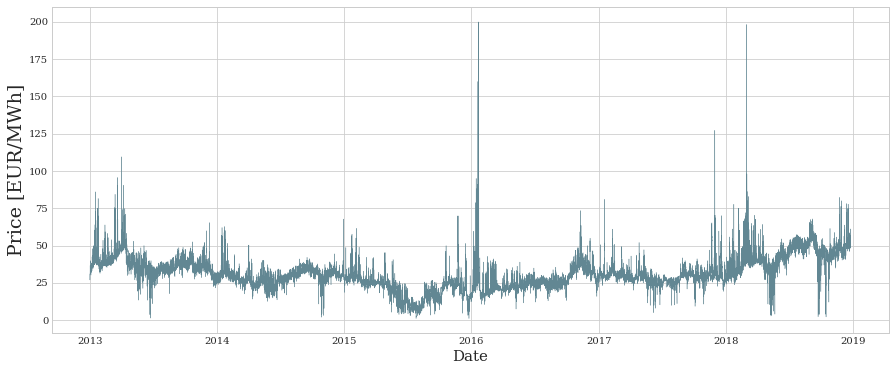

In [ ]:
import pandas as pd
from nixtla.data.datasets.epf import EPF, EPFInfo
from nixtla.data.tsloader_general import TimeSeriesLoader

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 19

# Load and plot data
Y_df, X_df, S_df = EPF.load_groups(directory='../data', groups=['NP'])

fig = plt.figure(figsize=(15, 6))
plt.plot(Y_df.ds, Y_df.y.values, color='#628793', linewidth=0.4)
plt.ylabel('Price [EUR/MWh]', fontsize=19)
plt.xlabel('Date', fontsize=15)
# plt.savefig('./results/NP.png', bbox_inches = 'tight')
plt.show()

### DECLARE MODEL AND DATA PARAMETERS

In [ ]:
# Architecture parameters
mc = {}
mc['model'] = 'nbeats'
mc['activation'] = 'selu'

# mc['input_size_multiplier'] = 1
# mc['output_size'] = 24*7

mc['input_size_multiplier'] = 7
mc['output_size'] = 24

mc['stack_types'] = ['trend', 'seasonality', 'exogenous_wavenet']
mc['n_blocks'] = [1, 1, 1]
mc['n_layers'] = [2, 2, 2]
# mc['stack_types'] = ['trend', 'seasonality']
# mc['n_blocks'] = [1, 1]
# mc['n_layers'] = [2, 2]

mc['n_hidden'] = 128
mc['exogenous_n_channels'] = 8
mc['x_s_n_hidden'] = 0
mc['shared_weights'] = False
mc['n_harmonics'] = 4
mc['n_polynomials'] = 2

# Optimization and regularization parameters
mc['initialization'] = 'lecun_normal'
mc['learning_rate'] = 0.0007
mc['batch_size'] = 128
mc['lr_decay'] = 0.5
mc['n_lr_decay_steps'] = 3
mc['n_iterations'] = 60#_000
mc['early_stopping'] = 50
mc['eval_freq'] = 500
mc['batch_normalization'] = False
mc['dropout_prob_theta'] = 0.51
mc['dropout_prob_exogenous'] = 0.44
mc['l1_theta'] = 0
mc['weight_decay'] = 0
mc['loss'] = 'MAE'
mc['loss_hypar'] = 0.5
mc['val_loss'] = mc['loss']
mc['random_seed'] = 1

# Data Parameters
mc['idx_to_sample_freq'] = 1
mc['n_val_weeks'] = 52
mc['window_sampling_limit'] = 500_000
mc['normalizer_y'] = None
mc['normalizer_x'] = 'median'
mc['complete_inputs'] = False
mc['frequency'] = 'H'
mc['seasonality'] = 24

# # Within decomposition
# mc['learning_rate'] = 0.001
# mc['batch_size'] = 512 #256
# mc['weight_decay'] = 0.00005
# mc['n_harmonics'] = 3
# mc['n_polynomials'] = 10
# mc['dropout_prob_theta'] = 0
# mc['dropout_prob_exogenous'] = 0

print(65*'=')
print(pd.Series(mc))
print(65*'=')

mc['n_hidden'] = len(mc['stack_types']) * [ [int(mc['n_hidden']), int(mc['n_hidden'])] ]

model                                                      nbeats
activation                                                   selu
input_size_multiplier                                           7
output_size                                                    24
stack_types               [trend, seasonality, exogenous_wavenet]
n_blocks                                                [1, 1, 1]
n_layers                                                [2, 2, 2]
n_hidden                                                      128
exogenous_n_channels                                            8
x_s_n_hidden                                                    0
shared_weights                                              False
n_harmonics                                                     4
n_polynomials                                                   2
initialization                                       lecun_normal
learning_rate                                              0.0007
batch_size

### INSTANTIATE LOADERS AND MODEL

In [ ]:
from nixtla.experiments.utils import create_datasets
# from nixtla.models.nbeats.nbeats import Nbeats

if not ('exogenous_wavenet' in mc['stack_types']):
    X_df = X_df[['unique_id', 'ds', 'week_day']]

train_ts_dataset, outsample_ts_dataset, scaler_y = create_datasets(mc=mc, Y_df=Y_df, X_df=X_df, 
                                                                   S_df=S_df, ds_in_test=728*24,
                                                                   shuffle_outsample=False)

train_ts_loader = TimeSeriesLoader(ts_dataset=train_ts_dataset,
                                   model='nbeats',
                                   window_sampling_limit=int(mc['window_sampling_limit']),
                                   input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                   output_size=int(mc['output_size']),
                                   idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                   batch_size=int(mc['batch_size']),
                                   complete_inputs=mc['complete_inputs'],
                                   complete_sample=False,
                                   shuffle=True)

val_ts_loader = TimeSeriesLoader(ts_dataset=outsample_ts_dataset,
                                 model='nbeats',
                                 window_sampling_limit=int(mc['window_sampling_limit']),
                                 input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                 output_size=int(mc['output_size']),
                                 idx_to_sample_freq=int(mc['output_size']),
                                 batch_size=int(mc['batch_size']),
                                 complete_inputs=False,
                                 complete_sample=False,
                                 shuffle=False)

model = Nbeats(input_size_multiplier=mc['input_size_multiplier'],
               output_size=int(mc['output_size']),
               shared_weights=mc['shared_weights'],
               initialization=mc['initialization'],
               activation=mc['activation'],
               stack_types=mc['stack_types'],
               n_blocks=mc['n_blocks'],
               n_layers=mc['n_layers'],
               n_hidden=mc['n_hidden'],
               n_harmonics=int(mc['n_harmonics']),
               n_polynomials=int(mc['n_polynomials']),
               x_s_n_hidden=int(mc['x_s_n_hidden']),
               exogenous_n_channels=int(mc['exogenous_n_channels']),
               batch_normalization = mc['batch_normalization'],
               dropout_prob_theta=mc['dropout_prob_theta'],
               dropout_prob_exogenous=mc['dropout_prob_exogenous'],
               learning_rate=float(mc['learning_rate']),
               lr_decay=float(mc['lr_decay']),
               n_lr_decay_steps=float(mc['n_lr_decay_steps']),
               weight_decay=mc['weight_decay'],
               l1_theta=mc['l1_theta'],
               n_iterations=int(mc['n_iterations']),
               early_stopping=int(mc['early_stopping']),
               loss=mc['loss'],
               loss_hypar=float(mc['loss_hypar']),
               val_loss=mc['val_loss'],
               frequency=mc['frequency'],
               seasonality=int(mc['seasonality']),
               random_seed=int(mc['random_seed']))

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2016-12-27 2018-12-24 23:00:00
          1.0         2013-01-01 2016-12-26 23:00:00
INFO:root:Total data 			52416 time stamps
INFO:root:Available percentage=100.0, 	52416 time stamps
INFO:root:Insample  percentage=66.67, 	34944.0 time stamps
INFO:root:Outsample percentage=33.33, 	17472.0 time stamps
INFO:root:

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2013-01-01 2016-12-26 23:00:00
          1.0         2016-12-27 2018-12-24 23:00:00
INFO:root:Total data 			52416 time stamps
INFO:root:Available percentage=100.0, 	52416 time stamps
INFO:root:Insample  percentage=33.33, 	17472.0 time 

### TRAIN MODEL

In [ ]:
model.fit(train_ts_loader=train_ts_loader, 
          val_ts_loader=val_ts_loader, 
          eval_freq=mc['eval_freq'])



============================== Start fitting ==============================
Step: 60, Time: 1.923, Insample MAE: 3.63974, Outsample MAE: 2.74458
==============================  End fitting  ==============================




### MAKE AND PLOT PREDICTION DECOMPOSITION

In [ ]:
# Make predictions
Y_hat_df = model.forecast(Y_df=Y_df, X_df=X_df, f_cols=None, return_decomposition=True)

# if not ('exogenous_wavenet' in mc['stack_types']):
#     Y_hat_file = f'./results/{Y_df.unique_id[0]}_nbets_predictions.csv'
# else:
#     Y_hat_file = f'./results/{Y_df.unique_id[0]}_nbetsx_predictions.csv'    
# Y_hat_df.to_csv(Y_hat_file, index=False)


# Filter and rename
Y_hat_df = Y_hat_df[(Y_hat_df.ds >= "2017-12-18") & (Y_hat_df.ds < "2017-12-19")]
# Y_hat_df = Y_hat_df[(Y_hat_df.ds >= "2013-05-28") & (Y_hat_df.ds < "2013-06-04")]
Y_hat_df = Y_hat_df.rename(columns={'y': 'True',
                                    'y_hat': 'Forecast',
                                    'level': 'Level', 
                                    'trend': 'Trend',
                                    'seasonality': 'Seasonality',
                                    'exogenous_wavenet': 'Exogenous',
                                    'residual': 'Residual'})

# Format date stamp
if mc['output_size']==24:
    x_plot = Y_hat_df.ds.values
    #x_plot_min = str(Y_hat_df.ds.min())[:16]
    #x_plot_max = str(Y_hat_df['ds'].max())[:16]
    x_plot_min = pd.to_datetime(x_plot.min()).strftime('%B %d, %Y, %R')
    x_plot_max = pd.to_datetime(x_plot.max()).strftime('%R')
    Y_hat_df['ds'] = Y_hat_df.ds.dt.hour.values

if mc['output_size']>24:
    x_plot = Y_hat_df.ds.values
    x_plot_min = pd.to_datetime(x_plot.min()).strftime('%B %d, %Y')
    x_plot_max = pd.to_datetime(x_plot.max()).strftime('%B %d, %Y')
    
# If not exogenous fill with nan (plot purposes)
if 'Exogenous' not in Y_hat_df.columns:
    exog = np.empty(len(Y_hat_df))
    exog[:] = np.nan
    Y_hat_df['Exogenous'] = exog
    
Y_hat_df

,unique_id,ds,True,Forecast,Level,Trend,Seasonality,Exogenous,Residual
43488,NP,0,28.22,30.939215,28.59,1.871345,-1.220348,1.698218,-2.719215
43489,NP,1,27.90,30.279726,28.59,1.924895,-1.922946,1.687776,-2.379726
43490,NP,2,27.55,31.001251,28.59,1.975807,-1.234912,1.670356,-3.451251
43491,NP,3,27.39,30.683334,28.59,2.024080,-1.589670,1.658925,-3.293334
43492,NP,4,28.04,31.734425,28.59,2.069716,-0.591319,1.666029,-3.694425
43493,NP,5,29.94,34.100765,28.59,2.112713,1.735939,1.662114,-4.160765
43494,NP,6,32.14,32.409931,28.59,2.153073,0.010571,1.656287,-0.269931
43495,NP,7,42.11,34.955902,28.59,2.190794,2.520308,1.654800,7.154098
43496,NP,8,45.07,35.117229,28.59,2.225877,2.644646,1.656706,9.952771
43497,NP,9,45.08,34.362392,28.59,2.258322,1.873878,1.640195,10.717608


Hours [December 18, 2017, 00:00 to 23:00]


<Figure size 1152x900 with 0 Axes>

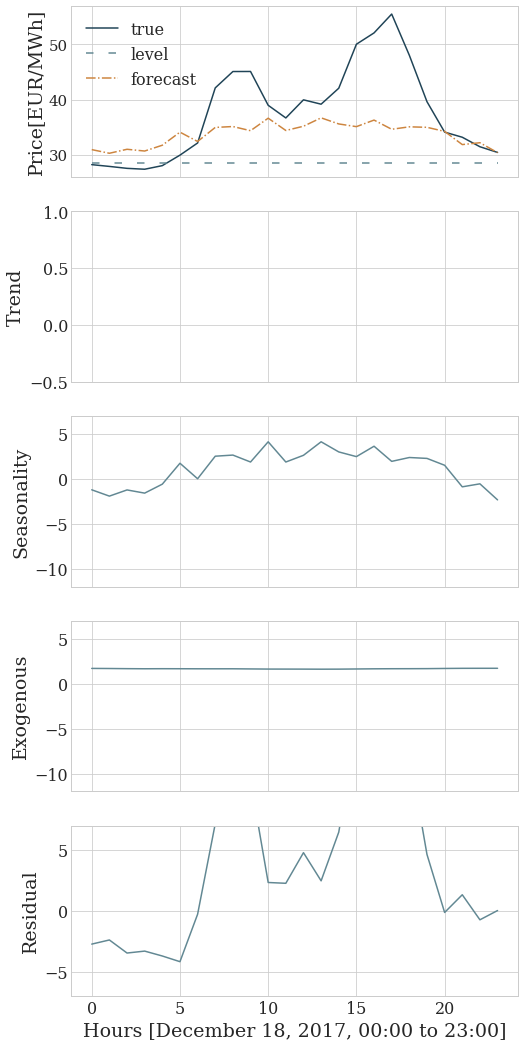

In [ ]:
# Plot Decomposition
x_axis_str = f'Hours [{x_plot_min} to {x_plot_max}]'
print(x_axis_str)

fig = plt.figure(figsize=(16, 12.5))
if mc['output_size']==24: fig = plt.figure(figsize=(8, 12.5))
ax0 = plt.subplot2grid((5,1),(0, 0))
ax1 = plt.subplot2grid((5,1),(1, 0))
# ax2 = plt.subplot2grid((5,1),(2, 0), sharey=ax1)
# ax3 = plt.subplot2grid((5,1),(3, 0), sharey=ax1)
# ax4 = plt.subplot2grid((5,1),(4, 0), sharey=ax1)
ax2 = plt.subplot2grid((5,1),(2, 0))
ax3 = plt.subplot2grid((5,1),(3, 0))
ax4 = plt.subplot2grid((5,1),(4, 0))

axs = [ax0, ax1, ax2, ax3, ax4]

axs[0].plot(Y_hat_df['ds'], Y_hat_df['True'], c='#204457', label='true')
axs[0].plot(Y_hat_df['ds'], Y_hat_df['Level'], c='#628893', label='level',
            linestyle=(0,(5,10)))
axs[0].plot(Y_hat_df['ds'], Y_hat_df['Forecast'], c='peru', label='forecast', 
            linestyle='dashdot')
axs[0].set_ylabel('Price[EUR/MWh]', fontsize=FONTSIZE)
axs[0].yaxis.set_tick_params(labelsize=FONTSIZE-4)
axs[0].set_xticklabels([])

for i, comp in enumerate(['Trend', 'Seasonality', 'Exogenous', 'Residual']):
    axs[i+1].plot(Y_hat_df['ds'], Y_hat_df[comp], c='#628893')
    axs[i+1].set_ylabel(comp, fontsize=FONTSIZE)
    axs[i+1].yaxis.set_tick_params(labelsize=FONTSIZE-3)
    axs[i+1].xaxis.set_tick_params(labelsize=FONTSIZE-3)
        
    if i<3:
        axs[i+1].set_xticklabels([])

    if np.sum(np.isnan(Y_hat_df[comp]))==len(Y_hat_df[comp]):
        axs[i+1].set_visible(False)
        
    # Trend
    if i==0:
        #axs[i+1].set_ylim(-1, 4)
        axs[i+1].set_ylim(-0.5, 1)
    
    # Seasonality
    if i==1:
        #axs[i+1].set_ylim(-4, 7)
        axs[i+1].set_ylim(-12, 7)
    
    # Exogenous
    if i==2:
        #axs[i+1].set_ylim(-6, 25)
        axs[i+1].set_ylim(-12, 7)
            
    # Residual
    if i==3:
        #axs[i+1].set_ylim(-6, 25)
        axs[i+1].set_ylim(-7, 7)

axs[0].legend(prop={'size': FONTSIZE-3})
axs[4].set_xlabel(x_axis_str, fontsize=FONTSIZE)

plt.tight_layout()
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                    top=1.2, wspace=0.2, hspace=0.2)
plt.savefig('./results/variance_decomposition.pdf', bbox_inches = 'tight')
plt.show()